## Part 2 - Neural Network Implementation for Image Segmentation

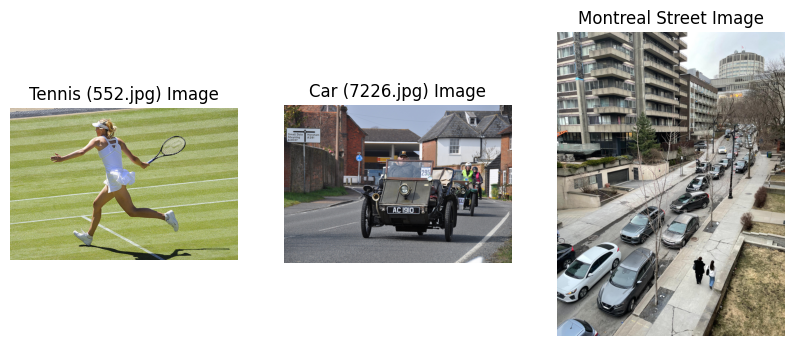

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import visualize
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline

# Load image Google Drive
# image_path = '/content/drive/My Drive/ECSE415_computer_vision/A5/'
image_path = r"C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\Assignments\A5"
tennis_image = cv2.imread(image_path + r"\Part 2\000000000552.jpg")
car_image = cv2.imread(image_path + r"\Part 2\000000007226.jpg")
street_image = cv2.imread(image_path + r"\Part 2\image_street.jpg")

images = [tennis_image, car_image, street_image]
image_names = ['Tennis', 'Car', 'Montreal street']

# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(tennis_image, cv2.COLOR_BGR2RGB))
plt.title("Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title("Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(street_image, cv2.COLOR_BGR2RGB))
plt.title("Montreal Street Image")
plt.axis('off')
plt.show()


### 1. Implement the pre-trained Mask R-CNN and YOLOv8n-seg model and run them on the 552.jpg and 7726.jpg image included in the assignment folder.

In [36]:
# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

transform = T.Compose([T.ToTensor()])

# List to store the predictions
predictions = []

# Loop over the images and make the predictions
for image in images:
  # Convert the image to a tensor
  image_tensor = transform(image)
  # Get the model's prediction
  with torch.no_grad():
    prediction = model([image_tensor.to(torch.float32)])
  # Add the prediction to the list
  predictions.append(prediction)

# COCO_INSTANCE_CATEGORY_NAMES provided on the RCNN github
COCO_INSTANCE_CATEGORY_NAMES = [
  '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
  'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
  'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
  'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
  'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
  'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
  'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
  'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
  'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
  'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

### 2. Display the result that shows the bounding boxes, object classes, and segmentations inside each bounding box.


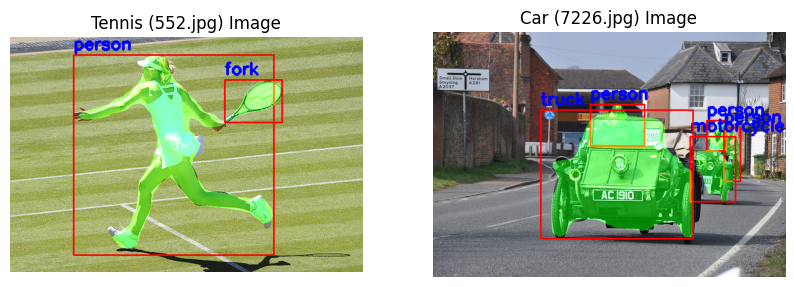

In [37]:
def create_mask(image, mask, color=(0, 255, 0)):
  mask = mask.mul(255).byte().cpu().numpy()
  color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  color_mask[mask > 128] = np.array(color, dtype=np.uint8)
  return cv2.addWeighted(image, 1, color_mask, 0.5, 0)

def draw_box(image, box, color=(0, 0, 255)):
  cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
  return image

def draw_label(image, box, label, color=(255, 0, 0)):
  cv2.putText(image, label, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
  return image

def process_image_with_predictions(image, prediction, threshold=0.75):
  for element in range(len(prediction[0]['masks'])):
    mask = prediction[0]['masks'][element, 0]
    score = prediction[0]['scores'][element].item()
  
    if score > threshold:
      image = create_mask(image, mask)
      box = prediction[0]['boxes'][element].cpu().numpy()
      image = draw_box(image, box)
  
      label = prediction[0]['labels'][element].item()
      label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
      image = draw_label(image, box, label_name)
  
  return image

labelled_tennis_image = process_image_with_predictions(tennis_image, predictions[0])
labelled_car_image = process_image_with_predictions(car_image, predictions[1])
labelled_street_image = process_image_with_predictions(street_image, predictions[2])


# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(labelled_tennis_image, cv2.COLOR_BGR2RGB))
plt.title("Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(labelled_car_image, cv2.COLOR_BGR2RGB))
plt.title("Car (7226.jpg) Image")
plt.axis('off')
plt.show()

### 3. Repeat steps 1 and 2 for an image of a Montreal street scene that you took with your own camera. 
You can use the image that you acquired for Assignment 4.


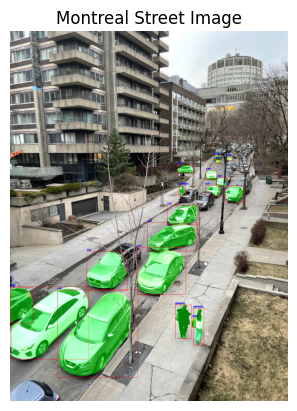

In [38]:
plt.subplot(1, 1, 1)
plt.imshow(cv2.cvtColor(labelled_street_image, cv2.COLOR_BGR2RGB))
plt.title("Montreal Street Image")
plt.axis('off')
plt.show()

### 4. Compare the performance of these two models and explain the steps that Mask R- CNN took to achieve the final result.


